#Imports

In [1]:
cd ./drive/MyDrive/ML/HW\ 1

/content/drive/MyDrive/ML/HW 1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import *
from sklearn import svm
from sklearn import tree

#Load dataset

In [4]:
dataset = pd.read_csv("./mapping_traces_O0.csv", sep = "\t")

In [5]:
dataset

,instructions,source_line,line_number,function_name,program,bug
0,movl HIGHVAL l 19 1,int32t l 19 1 = ( -8 ) ;,2517,func_47__0,/home/stepping/data_source_asm_trace_p2/proces...,0
1,movl HIGHVAL l 82 6,int32t l 25 73 = ( -1 ) ;,1994,func_25__0,/home/stepping/data_source_asm_trace_p2/proces...,1
2,movq l 15 07 5 %rcx movq l 15 06 1 %rax movq M...,( * * l 15 06 1 ) = l 15 07 5 ;,2171,func_1__0,/data_source_asm_trace_train_o0_p3/process_17/...,0
3,movabsq HIGHVAL %rax cmpq %rax MEM je MEM mova...,( ( g 14 5 = = & l 15 8 ) ? ( void ) ( 0...,2096,func_1__0,/home/stepping/data_source_asm_trace_p2/proces...,1
4,movw HIGHVAL l 41 89,int16t l 41 89 = ( -5 ) ;,1955,func_4__0,/home/stepping/data_source_asm_trace_p2/proces...,0
...,...,...,...,...,...,...
99995,movsbl MEM %eax addq 48 %rsp popq %rbp retq,return g 88 ;,2539,func_54__0,/home/stepping/data_source_asm_trace_p2/proces...,0
99996,movl HIGHVAL l 74 2,int32t l 74 2 = ( -1 ) ;,1826,func_7__0,/home/stepping/data_source_asm_trace_p2/proces...,0
99997,movw MEM %ax movb %al MEM,"struct S 0 l 17 58 = { HIGHVAL , 6 , 14...",1890,func_4__0,/home/stepping/data_source_asm_trace_p2/proces...,1
99998,leaq l 53 %rax movq %rax l 87,int32t * l 87 = & l 53 ;,2080,func_41__0,/home/stepping/data_source_asm_trace_p2/proces...,0


We can see that this is a balanced dataset

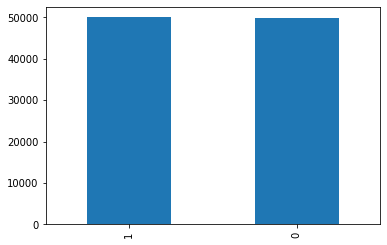

In [6]:
dataset["bug"].value_counts().plot(kind = "bar")

#Preprocess functions

In [15]:
# Returns a numpy array with the model input. The input is an array of length len(vocab) + 2. 
# In the first len(vocab) elements there is a number corresponding to how many times the i-th word 
# in the vocabulary appears in the entry, while the last two elements correspond 
# to a counter of how many equal and different numbers appear in the entry.
# An entry is the concatenation of the phrase in the 'instructions' column 
# and the phrase in the 'source_line' column.
# Parameters:
# - instruction: column of the dataset labelled "instructions";
# - source_line: column of the dataset labelled "source_line";
# - vocab      : vocabulary of words to consider when encoding an entry.
def input_x(instruction, source_line, vocab):
  x_all = []
  for i in range(len(instruction)):
    instruction_list = instruction[i].split()
    source_line_list = source_line[i].split()
    phrase = instruction_list + source_line_list
    encode = np.zeros(len(vocab) + 2)
    for word_i in range(len(vocab)):
      if (vocab[word_i] in phrase):
        encode[word_i] += 1
    number_in_instruction = []
    number_in_source_line = []
    for word_instruction in instruction_list:
      if (not word_instruction.isalpha()):
        number_in_instruction.append(word_instruction)
    for word_source_line in source_line_list:
      if (not word_source_line.isalpha()):
        number_in_source_line.append(word_source_line)
    for number in number_in_instruction:
      if (number in number_in_source_line):
        encode[-2] += 1
      else:
        encode[-1] += 1
    x_all.append(encode)
  return np.array(x_all)

# Returns a vocabulary containing all words that are not numbers and different from 
# some specific characters, which appear at least 101 times. The words are taken 
# from the columns "instructions" and "source_line".
# Parameter:
# - dataset: the dataset we are taking into account.
def vocabulary(dataset):
  instruction = np.array(dataset["instructions"])
  source_line = np.array(dataset["source_line"])
  words = []
  for i in range(len(instruction)):
    instruction_list = instruction[i].split()
    source_line_list = source_line[i].split()
    words += instruction_list + source_line_list
  vocab_all = dict(Counter(words))
  vocab = []
  for key, value in vocab_all.items():
    if (key.isalpha() and value > 100 and key not in ["(", ")", ";", ",", ".", ":","[", "]", "{", "}"]):
      vocab.append(key)
  return vocab

# Returns the model input considering a specific dataset.
# Parameters:
# - dataset: the dataset we are taking into account;
# - vocab  : the vocabulary of this dataset.
def xall(dataset, vocab):
  instruction = np.array(dataset["instructions"])
  source_line = np.array(dataset["source_line"])
  return input_x(instruction, source_line, vocab)


#Model

In [16]:
# Class allowing the management of different models, depending on the input string, 
# for the modularisation of the train, test and k-fold cross validation phases.
class model():
  # Parameters:
  # - vocab: vocabulary of words to consider when encoding an entry;
  # - x_all: input of the model;
  # - y_all: ground truth of the x_all;
  # - name : name of the model to be created. The default value is "DecisionTreeClassifier_entropy".
  def __init__(self, vocab, x_all, y_all, name = "DecisionTreeClassifier_entropy"):
    self.name = name
    self.vocab = vocab  
    self.x_all = x_all
    self.y_all = y_all
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x_all, self.y_all, test_size=0.333, random_state=117)
    
    if (self.name == "LogisticRegression_l2"):
      self.model = LogisticRegression(max_iter=len(self.x_train), penalty="l2")
    if (self.name == "LogisticRegression_none"):
      self.model = LogisticRegression(max_iter=len(self.x_train), penalty="none")
    if (self.name == "DecisionTreeClassifier_gini"):
      self.model = tree.DecisionTreeClassifier(criterion = "gini")
    if (self.name == "DecisionTreeClassifier_entropy"):
      self.model = tree.DecisionTreeClassifier(criterion = "entropy")
    if (self.name == "SVM_linear"):
      self.model = svm.SVC(kernel='linear')
    if (self.name == "GaussianNB"):
      self.model = GaussianNB()
    if (self.name == "MultinomialNB"):
      self.model = MultinomialNB()

  # Training phase with fit function and print of running time.
  def train(self):
    start_time = time.time()
    print("Training for model " + self.name + " is started")
    self.model.fit(self.x_train, self.y_train)    
    print("Training ended in %s seconds" % round((time.time() - start_time), 3))
  
  # K-fold crossvalidation with a print of running time and 
  # the average score of the accuracy obtained plus the standard deviation.
  # Parameter:
  # - k: number of subsets, the default value is 5.
  def k_fold_crossvalidation(self, k = 5):
    start_time = time.time()
    print("K-fold cross validation for model " + self.name + " is started")
    cv = ShuffleSplit(n_splits=k, test_size=0.333, random_state=15)
    scores = cross_val_score(self.model, self.x_all, self.y_all, cv=cv)
    print("K-fold cross validation ended in %s seconds" % round((time.time() - start_time), 3))
    print("Scores:", scores)
    print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  
  # Test phase with a print of running time and accuracy. 
  # A table with f1, precision and recall scores is also printed.
  def test(self):
    start_time = time.time()
    print("Test of the model " + self.name + " is started")
    acc_svm = self.model.score(self.x_test, self.y_test)    
    y_pred = self.model.predict(self.x_test)
    class_names = np.array(["bug_free","bug"])
    print("Test ended in %s seconds" % round((time.time() - start_time), 3))
    print("Accuracy %.3f" %acc_svm)
    print(classification_report(self.y_test, y_pred, labels=None, target_names=class_names, digits=3))
  
  # Blind test using another testset without gorund truth.
  def blind_test(self):
    bt = pd.read_csv("./blind_test.csv", sep = "\t")
    x_all = xall(bt, self.vocab)
    y_pred = self.model.predict(x_all)
    out_text = []
    for result in y_pred:
      out_text += str(result)
    with open("./1747042.txt", 'w') as out:
      out.write('\n'.join(out_text))

#Results
In this section, the input, ground truth and vocabulary will be created and then run in order, for each type of model:
1.   Train;
2.   K-fold crossvalidation;
3.   Test.



In [9]:
# Voabulary.
vocab = vocabulary(dataset)
# Inputs.
x_all = xall(dataset, vocab)
# Ground truth.
y_all = np.array(dataset["bug"])

**NB. The print of all models is done in one cell**

In [10]:
# List of model names.
model_names = ["DecisionTreeClassifier_gini", "DecisionTreeClassifier_entropy",
               "GaussianNB", "MultinomialNB",
               "LogisticRegression_l2", "LogisticRegression_none",
               "SVM_linear"]

# Dictionary with key the model name and with value the model.
models = {}
# For each model print the outputs of train, k-fold crossvalidation and test
for name in model_names:  
  print("###############################")
  print(name)
  print("###############################")
  m = model(vocab, x_all, y_all, name)
  m.train()
  print("")
  m.k_fold_crossvalidation()
  print("")
  m.test()
  models[name] = m
  print("\n\n")

###############################
DecisionTreeClassifier_gini
###############################
Training for model DecisionTreeClassifier_gini is started
Training ended in 0.628 seconds

K-fold cross validation for model DecisionTreeClassifier_gini is started
K-fold cross validation ended in 3.052 seconds
Scores: [0.9793994  0.9796997  0.97978979 0.97975976 0.97912913]
Accuracy: 0.980 (+/- 0.00)

Test of the model DecisionTreeClassifier_gini is started
Test ended in 0.03 seconds
Accuracy 0.980
              precision    recall  f1-score   support

    bug_free      0.978     0.982     0.980     16725
         bug      0.982     0.977     0.979     16575

    accuracy                          0.980     33300
   macro avg      0.980     0.980     0.980     33300
weighted avg      0.980     0.980     0.980     33300




###############################
DecisionTreeClassifier_entropy
###############################
Training for model DecisionTreeClassifier_entropy is started
Training ended in 0

#Blindtest
The blindtest was done using the decision tree model with the "entropy" criterion as it gave the best results.

In [14]:
# Performing the blind test and saving the result
models["DecisionTreeClassifier_entropy"].blind_test()